In [1]:
import pandas as pd
from sklift.models import TwoModels
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Data

In [4]:
data_path = "../../data/preprocessed/x5-uplift-features/"

df = pd.read_csv(data_path + "features_with_target.csv")
df

,client_id,age,gender,epr_mean,epr_std,epr_median,epr_skew,eps_mean,eps_std,eps_median,eps_skew,rpr_mean,rpr_std,rpr_median,rpr_skew,rps_mean,rps_std,rps_median,rps_skew,sum_mean,sum_std,sum_median,sum_skew,treatment_flg,target
0,0001f552b0,33,F,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,6.158333,10.634336,1.60,2.547242,0.000000,0.000000,0.0,0.000000,427.193333,307.178208,335.120,0.659669,1.0,1.0
1,00020e7b18,73,U,0.0,0.0,0.0,0.0,-1.176471,3.221897,0.0,-2.373464,16.823529,12.870556,15.50,0.802523,-31.411765,111.079229,0.0,-3.702573,1513.565294,951.441670,1374.500,1.110618,1.0,1.0
2,0004231e2a,56,F,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.000000,3.452535,1.85,0.465942,0.000000,0.000000,0.0,0.000000,477.916667,292.505116,381.000,0.390853,1.0,0.0
3,0008b2cb41,25,U,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,8.088889,9.269717,1.80,0.772569,0.000000,0.000000,0.0,0.000000,524.934444,648.084106,328.070,1.807648,1.0,1.0
4,0018650c30,35,U,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,5.083784,5.170891,3.10,2.021097,-6.378378,34.638169,0.0,-5.733762,525.112973,326.249867,585.000,0.348691,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39870,381ffd590b,31,M,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,10.695238,7.097181,10.90,0.482618,-11.047619,23.509828,0.0,-1.773429,1247.857143,710.032298,1228.870,0.620327,0.0,1.0
39871,382006deb4,53,U,0.0,0.0,0.0,0.0,-0.526316,2.232969,0.0,-4.006938,5.321053,5.863498,2.60,1.443846,-4.263158,10.274353,0.0,-2.238413,503.995263,385.419511,417.910,1.362780,0.0,1.0
39872,3824a10246,31,M,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,14.570588,16.694936,6.30,1.526712,0.000000,0.000000,0.0,0.000000,886.350000,574.790762,608.000,0.421705,1.0,1.0
39873,3827525e79,52,M,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.313725,7.357350,1.00,2.127366,-4.529412,25.056292,0.0,-6.050345,337.968627,400.006840,197.850,3.328584,1.0,1.0


In [11]:
def split_df(df):
    features = df[df.columns.difference(['treatment_flg', 'target', 'client_id', 'gender'])]
    y_target = df.target
    treatment = df.treatment_flg
    
    return features, y_target, treatment

# Models

## Two tower models

### Init

In [12]:
treatment_model = lgb.LGBMClassifier()
control_model = lgb.LGBMClassifier()

uplift_model = TwoModels(treatment_model, control_model, )

### Split

In [29]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.treatment_flg)

### Fit-predict

In [30]:
uplift_model.fit(*split_df(df_train))
uplift_predict = uplift_model.predict(split_df(df_test)[0])

## Metrics

In [31]:
features_test, y_test, treatment_test = split_df(df_test)

### Uplift at percentile

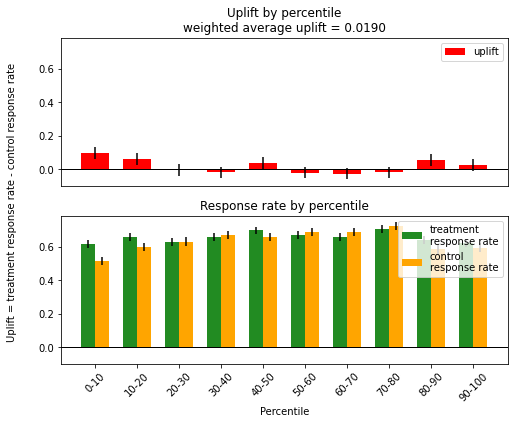

In [32]:
from sklift.viz import plot_uplift_by_percentile

ax_uplift, ax_rr = plot_uplift_by_percentile(y_test, uplift_predict, treatment_test, kind='bar')

### Uplift curve

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0150'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

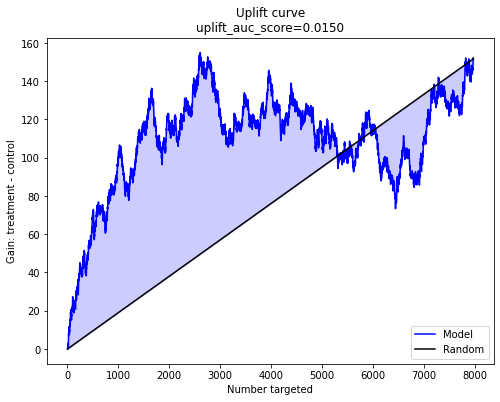

In [33]:
from sklift.viz import plot_uplift_curve

plot_uplift_curve(y_test, uplift_predict, treatment_test, perfect=False, )

### Uplift@30

In [34]:
from sklift import metrics

print("Uplift@30:", metrics.uplift_at_k(y_test, uplift_predict, treatment_test, strategy="by_group", k = 0.3))

Uplift@30: 0.05207639475849568
